In [84]:
import scipy.stats

def clopper_pearson_interval(k, n, alpha=0.6827):
    alpha = 1 - alpha
    lo = scipy.stats.beta.ppf(alpha / 2, k, n - k + 1) if k > 0 else 0.0
    hi = scipy.stats.beta.ppf(1 - alpha / 2, k + 1, n - k) if k < n else 1.0
    return lo, hi


# gaussian fit func
def gaussian(x, A, mu, sig):
    return A * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [85]:
## STANDARD IMPORTS
import os
import time
import h5py
import numpy as np
import numpy.ma as ma
import pandas as pd
import json
from tqdm import tqdm

# analysis
import scipy.stats
from scipy.optimize import curve_fit

# data handling
!pip3 install ../../../h5flow
import h5flow
from h5flow.data import dereference

## 3D PLOTTING
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm, colors
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm

Processing /Users/james/DUNE/h5flow
  Preparing metadata (setup.py) ... done
  Created wheel for h5flow: filename=h5flow-0.2.4-py3-none-any.whl size=31486 sha256=e0db31b4664f55aa6904794bff3332cbce644978929883fa639330f243796ca3
  Stored in directory: /private/var/folders/rc/blk_p25x629bs2hm6s03qd7r0000gp/T/pip-ephem-wheel-cache-8r5k75di/wheels/24/88/52/69f8c19ba5cdb192c9c8611f03e4d3b4e2b4c27d2131bc4e20
Successfully built h5flow
  Attempting uninstall: h5flow
    Found existing installation: h5flow 0.2.4
    Uninstalling h5flow-0.2.4:
      Successfully uninstalled h5flow-0.2.4


In [86]:
dirname = 'mc_processed_MiniRun5_1E19_RHC.flow.0000000.FLOW_nfiles_6_TrapType_evts_all'

# print configuration and hit configuration
config_filename = dirname+'/config.json'
with open(config_filename) as json_file:
    config = json.load(json_file)
    #print(json.dumps(config, indent=4))


# loop over nfiles from config.json
nfiles = config['nfiles']

spes_filenames = []
noise_filenames = []
hits_filenames = []
peaks_filenames = []
hits_config_filenames = []
true_hits_filenames = []

for i in range(nfiles):
    spes_filenames.append(dirname + f'/spes_evt_{i}.npz')
    noise_filenames.append(dirname + f'/noise_evt_{i}.npz')
    hits_filenames.append(dirname + f'/hits_evt_{i}.npz')
    peaks_filenames.append(dirname + f'/peaks_evt_{i}.npz')
    hits_config_filenames.append(dirname + f'/hits_config_{i}.json')
    true_hits_filenames.append(dirname + f'/true_hits_{i}.csv')

    with open(hits_config_filenames[i]) as json_file:
        hits_config = json.load(json_file)
        #print(f'Config for file {i}:')
        #
    # check if true hits file exists
    if os.path.exists(true_hits_filenames[i]):
        true_hits = pd.read_csv(true_hits_filenames[i])
        #print(f'True hits for file {i}:')
        #print(true_hits.head())



Available columns in true_hits: Index(['event_id', 'vertex_id', 'start_time', 'start_time_idx', 'tpc_num'], dtype='object')
Event 0, TPC 1, TrapType 1


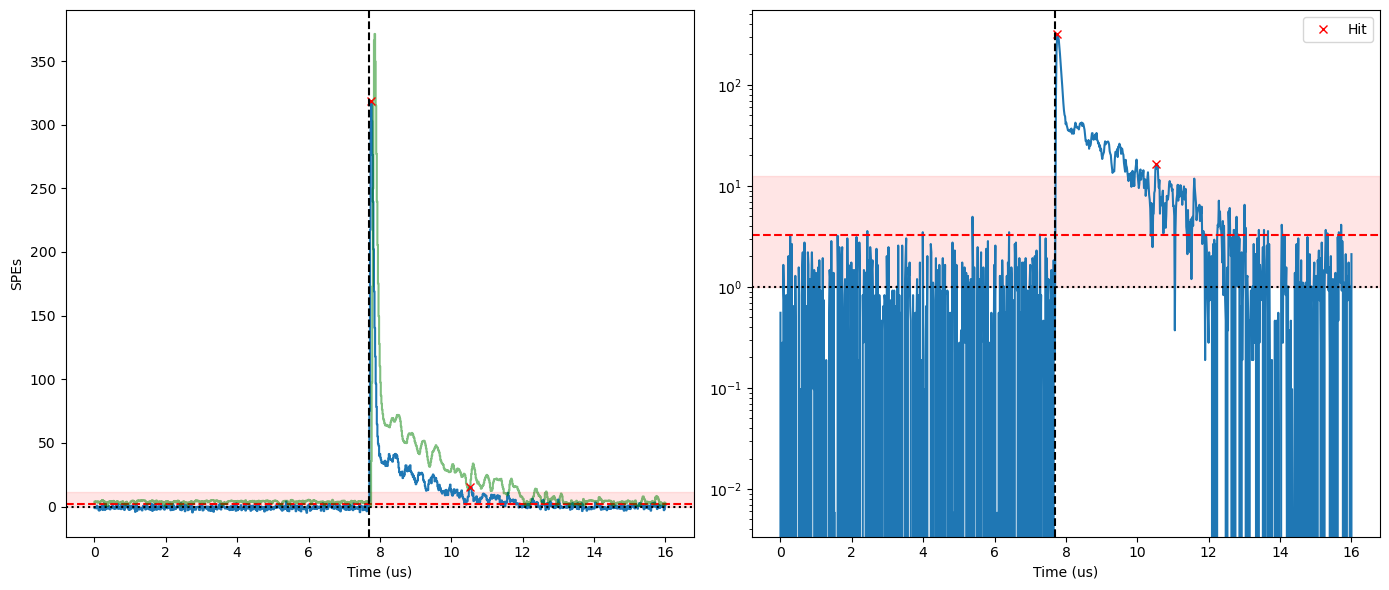

In [87]:
from scipy.ndimage import uniform_filter1d

# load hit finder config
with open(hits_config_filenames[0]) as json_file:
    hits_config = json.load(json_file)
n_noise_factor = hits_config['n_noise_factor']
n_bins_rolled = hits_config['n_bins_rolled']
n_sqrt_rt_factor = hits_config['n_sqrt_rt_factor']
pe_weight = hits_config['pe_weight']


# loading events
time_bins = np.linspace(0, 16, 1000)

# wvfms
summed_wvfms_file = np.load(spes_filenames[0])
summed_wvfms = np.array(summed_wvfms_file['arr_0'])

# noise thresholds
heights_file = np.load(noise_filenames[0])
heights = np.array(heights_file['arr_0'])

# loading hits
hits_file = np.load(hits_filenames[0])
hits = np.array(hits_file['arr_0'])

# true hits
true_hits_file = pd.read_csv(true_hits_filenames[0])
# use headers for dataframe
true_hits_headers = true_hits_file.columns  # Extract column names starting from the second column
true_hits = pd.DataFrame(true_hits_file.values, columns=true_hits_headers)


# plot the waveform of the trap with the highest wvfm in the event
for i_evt in range(1):

  # mask with the most hits
  i_evt_lrs = i_evt

  # skip events with no hits
  all_traps = summed_wvfms[i_evt_lrs]
  all_heights = heights[i_evt_lrs]
  all_hits = hits[i_evt_lrs]

  # true hits
  i_mask = np.argmax(all_hits.sum(axis=1))
  i_tpc = i_mask // 2
  # Verify column names in the true_hits DataFrame
  print("Available columns in true_hits:", true_hits.columns)

  # Replace "event_id" with the correct column name if it differs
  true_hits_list = true_hits[(true_hits["event_id"] == i_evt_lrs) & (true_hits["tpc_num"] == i_tpc)]
  events = true_hits_list["event_id"].values
  times = true_hits_list["start_time_idx"].values * 16 / 1000

  # get wvfm, threshold, and hits for the event
  wvfm = summed_wvfms[i_evt_lrs,i_mask]
  wvfm_rolled = np.roll(wvfm, n_bins_rolled)
  rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
  sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
  dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
  wvfm_gradient = np.gradient(wvfm)
  wvfm_grad2 = np.gradient(wvfm_gradient)
  wvfm_grad3 = np.gradient(wvfm_grad2)
  height = heights[i_evt_lrs,i_mask]
  hit = hits[i_evt_lrs,i_mask]
  hit_where = np.where(hit)[0]
  # verticle line at true hit position
  if len(hit_where) == 0:
    continue

  print(f'Event {i_evt_lrs}, TPC {i_mask // 2}, TrapType {i_mask % 2}')

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

  # Linear plot
  ax1.step(time_bins, wvfm)
  ax1.axhline(height, color='r', linestyle='--')
  ax1.axhspan(0,n_noise_factor*height, color='r', alpha=0.1)
  ax1.axhline(0, color='k', linestyle=':')
  ax1.step(time_bins, dynamic_threshold, color='g', alpha=0.5)
  #ax1.step(time_bins, wvfm_gradient, color='purple', alpha=0.5)
  #ax1.step(time_bins, wvfm_grad2, color='pink', alpha=0.5)
  #ax1.step(time_bins, wvfm_grad3, color='orange', alpha=0.5)
  ax1.step(hit_where * 16/1000, wvfm[hit_where], 'x', color='red', label='Hit')
  for t0 in times:
    #print(f'True hit at {t0}')
    ax1.axvline(t0, color='k', linestyle='--')
  #ax1.set_xlim(9, 10)
  #ax1.set_ylim(30, 50)
  ax1.set_xlabel('Time (us)')
  ax1.set_ylabel('SPEs')

  # Logarithmic plot
  ax2.plot(time_bins, wvfm + 1)
  ax2.axhline(height + 1, color='r', linestyle='--')
  ax2.axhspan(1,n_noise_factor*height+1, color='r', alpha=0.1)
  ax2.axhline(1, color='k', linestyle=':')
  #ax2.plot(time_bins, dynamic_threshold + 1, color='g', alpha=0.5)
  #ax2.plot(time_bins, wvfm_gradient + 1, color='purple', alpha=0.5)
  #ax2.plot(time_bins, wvfm_grad2 + 1, color='pink', alpha=0.5)
  #ax2.plot(time_bins, wvfm_grad3 + 1, color='orange', alpha=0.5)
  ax2.plot(hit_where * 16/1000, wvfm[hit_where] + 1, 'x', color='red', label='Hit')
  for t0 in times:
    #print(f'True hit at {t0}')
    ax2.axvline(t0, color='k', linestyle='--')
  ax2.set_yscale('log')
  ax2.set_xlabel('Time (us)')

  plt.legend()

  plt.tight_layout()
  plt.show()

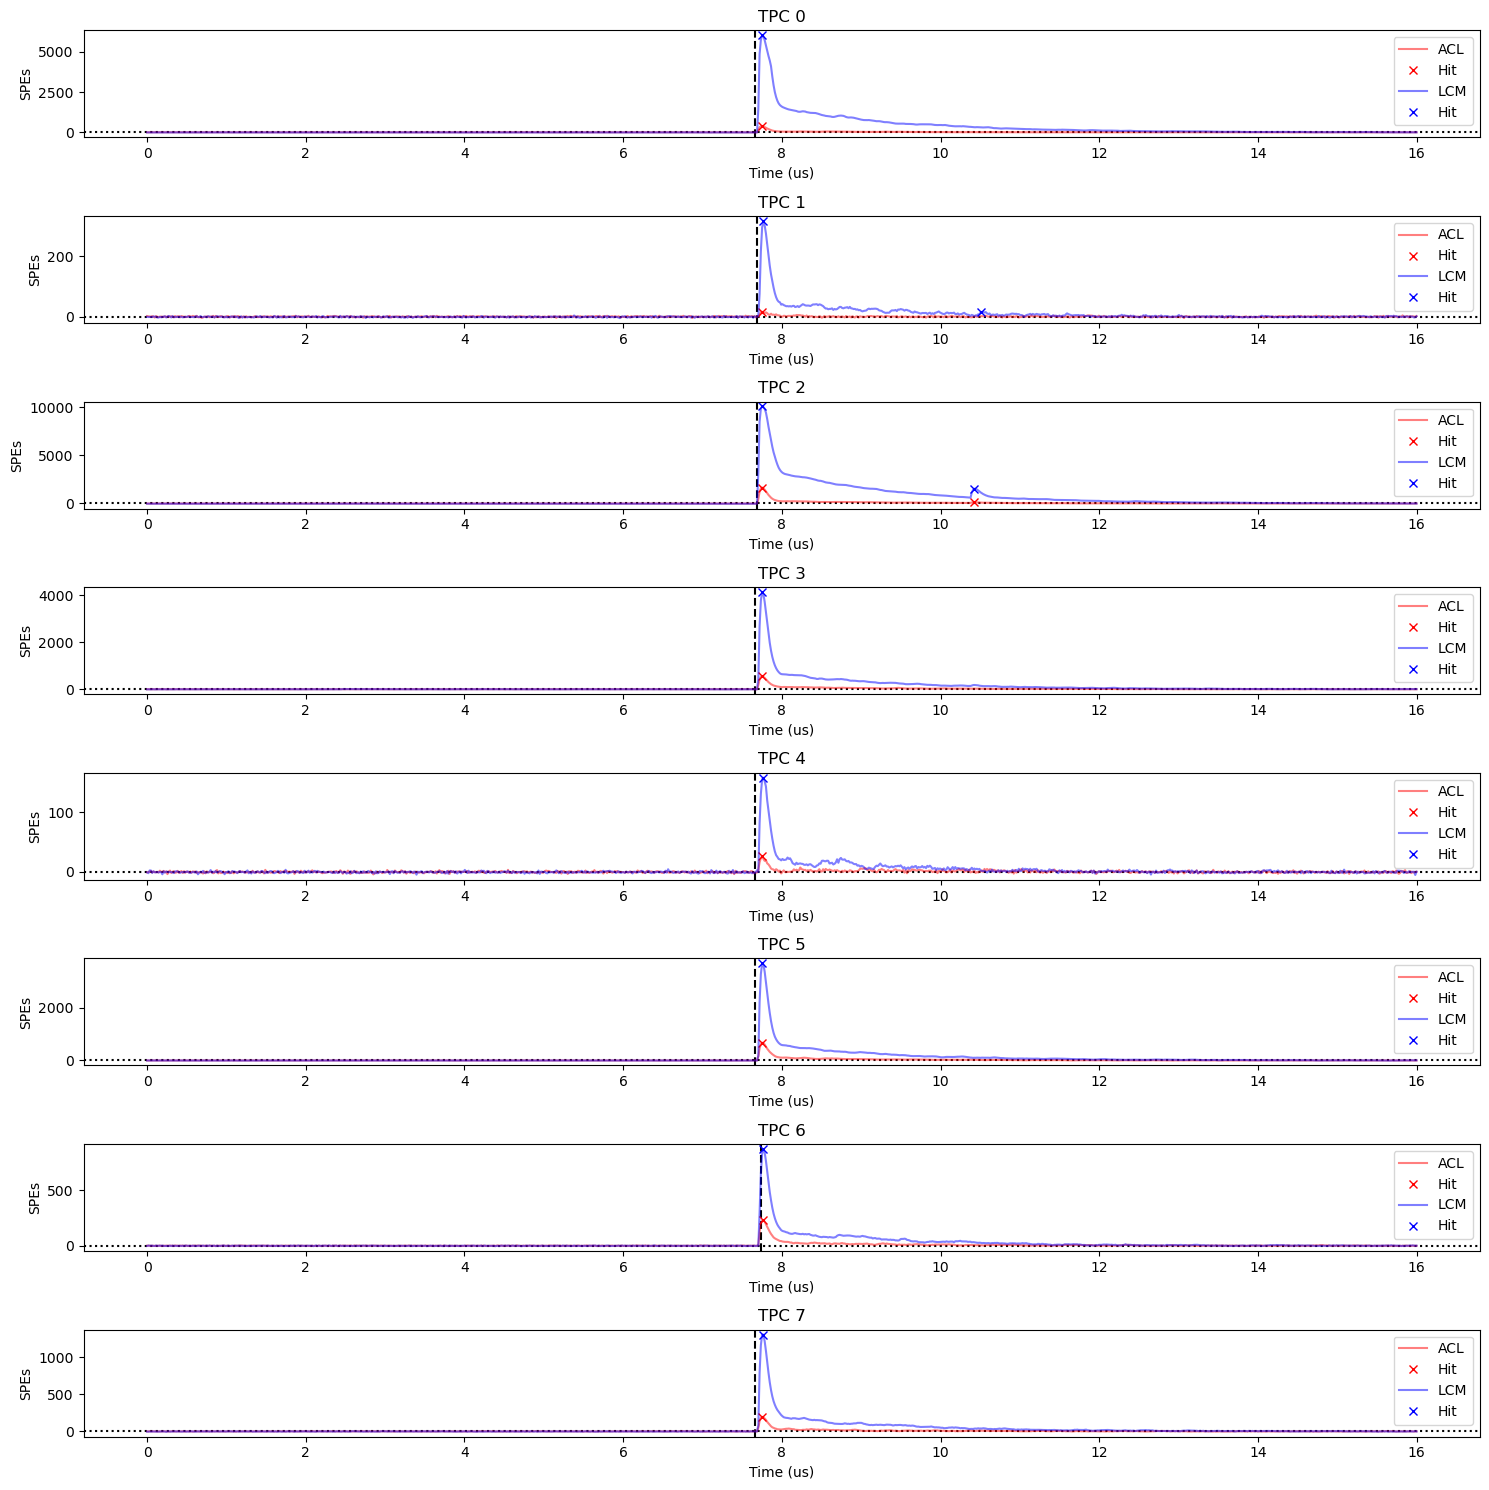

In [88]:
# plotting script to plot the summed traptype waveforms per tpc with interactions
def plot_summed_trap_waveform_per_tpc_with_interactions(i_evt, time_bins, summed_wvfms, hits, true_hits):

  # 2x2 TPC subplot grid, each with traptype sum waveforms
  fig, axs = plt.subplots(8, 1, figsize=(15, 15))

  for tpc in range(8):
    acl_mask = 2*tpc
    lcm_mask = 2*tpc + 1

    axs[tpc].axhline(0, color='k', linestyle=':')

    # get wvfm, threshold, and hits for the event
    acl_wvfm = summed_wvfms[i_evt, acl_mask]
    acl_hit = hits[i_evt, acl_mask]
    acl_hit_where = np.where(acl_hit)[0]

    lcm_wvfm = summed_wvfms[i_evt, lcm_mask]
    lcm_hit = hits[i_evt, lcm_mask]
    lcm_hit_where = np.where(lcm_hit)[0]

    # true hits
    true_hits_list = true_hits[(true_hits["event_id"] == i_evt) & (true_hits["tpc_num"] == tpc)]
    events = true_hits_list["event_id"].values
    times = true_hits_list["start_time_idx"].values * 16 / 1000

    # plot true hits
    for t0 in times:
      axs[tpc].axvline(t0, color='k', linestyle='--')

    axs[tpc].plot(time_bins, acl_wvfm, label='ACL', color='red', alpha=0.5)
    axs[tpc].plot(acl_hit_where * 16/1000, acl_wvfm[acl_hit_where], 'x', color='red', label='Hit')

    axs[tpc].plot(time_bins, lcm_wvfm, label='LCM', color='blue', alpha=0.5)
    axs[tpc].plot(lcm_hit_where * 16/1000, lcm_wvfm[lcm_hit_where], 'x', color='blue', label='Hit')

    axs[tpc].set_xlabel('Time (us)')
    axs[tpc].set_ylabel('SPEs')
    axs[tpc].set_title(f'TPC {tpc}')

    # legend
    axs[tpc].legend()

  plt.tight_layout()
  plt.show()

# load the event number
i_evt = 0

# load the time bins
time_bins = np.linspace(0, 16, 1000)

# wvfms
summed_wvfms_file = np.load(spes_filenames[0])
summed_wvfms = np.array(summed_wvfms_file['arr_0'])

# noise thresholds
heights_file = np.load(noise_filenames[0])
heights = np.array(heights_file['arr_0'])

# loading hits
hits_file = np.load(hits_filenames[0])
hits = np.array(hits_file['arr_0'])

# true hits
true_hits_file = pd.read_csv(true_hits_filenames[0])
# use headers for dataframe
true_hits_headers = true_hits_file.columns  # Extract column names starting from the second column
true_hits = pd.DataFrame(true_hits_file.values, columns=true_hits_headers)

plot_summed_trap_waveform_per_tpc_with_interactions(i_evt, time_bins, summed_wvfms, hits, true_hits)


In [89]:
tolerance = 12

# info by trap type (ArClight)
acl_rec_true_hits_tot = 0
acl_true_hits_tot = 0
acl_rec_hits_tot = 0
acl_delta_t = []
# info by trap type (LCM)
lcm_rec_true_hits_tot = 0
lcm_true_hits_tot = 0
lcm_rec_hits_tot = 0
lcm_delta_t = []

# info by trap type (ArClight) binned by pileup
acl_rec_true_hits_pu = []
acl_true_hits_pu = []
acl_rec_hits_pu = []
acl_delta_t_pu = []
# info by trap type (LCM) binned by pileup
lcm_rec_true_hits_pu = []
lcm_true_hits_pu = []
lcm_rec_hits_pu = []
lcm_delta_t_pu = []

# loop over files
for i_file in tqdm(range(0, nfiles), desc="Processing Files"):

    acl_rec_true_hits = 0
    acl_true_hits = 0
    acl_rec_hits = 0

    lcm_rec_true_hits = 0
    lcm_true_hits = 0
    lcm_rec_hits = 0

    # load true hits
    true_hits = pd.read_csv(true_hits_filenames[i_file])
    true_hit_idxs = true_hits['start_time_idx'].values

    # load ticks histogram of all hits
    hits_file = np.load(hits_filenames[i_file])
    hits_arr = hits_file['arr_0']
    flat_hits = np.sum(hits_arr, axis=(0,1))

    # loop over events
    for i_evt_lrs in range(hits_arr.shape[0]):

        # loop over traps
        for i_trap in range(hits_arr.shape[1]):

            # indexing for trap type
            is_acl = i_trap % 2 == 0
            i_tpc = i_trap // 2

            # get true hits for this event and trap
            true_hit_idxs_tpc = true_hits[(true_hits['event_id'] == i_evt_lrs) & (true_hits['tpc_num'] == i_tpc)]['start_time_idx'].values
            hits = np.where(hits_arr[i_evt_lrs, i_trap])[0]

            # add rec hits
            for i_hit in hits:
                if is_acl:
                    acl_rec_hits += 1
                    acl_rec_hits_pu.append(len(true_hit_idxs_tpc))
                else:
                    lcm_rec_hits += 1
                    lcm_rec_hits_pu.append(len(true_hit_idxs_tpc))

            # fill pileup histogram with length-of-true-hits length-of-true-hits times
            for true_hit_idx in true_hit_idxs_tpc:

                if is_acl:
                    # add true hits
                    acl_true_hits += 1
                    acl_true_hits_pu.append(len(true_hit_idxs_tpc))
                    # get true hit indices within tolerance of this hit
                    if hits.size > 0:
                        delta_ts = hits - true_hit_idx
                        delta_t = delta_ts[(delta_ts < tolerance) & (delta_ts > 0)]
                        if delta_t.size > 0:
                            acl_delta_t.append(min(delta_t))
                            # remove min(delta_t) from the list of available hits to match
                            hits = hits[delta_ts != min(delta_t)]
                            # add to true rec hits
                            acl_rec_true_hits += 1
                            acl_rec_true_hits_pu.append(len(true_hit_idxs_tpc))
                else:
                    # add true hits
                    lcm_true_hits += 1
                    lcm_true_hits_pu.append(len(true_hit_idxs_tpc))
                    # get true hit indices within tolerance of this hit
                    if hits.size > 0:
                        delta_ts = hits - true_hit_idx
                        delta_t = delta_ts[(delta_ts < tolerance) & (delta_ts > 0)]
                        if delta_t.size > 0:
                            lcm_delta_t.append(min(delta_t))
                            # remove min(delta_t) from the list of available hits to match
                            hits = hits[delta_ts != min(delta_t)]
                            # add to true rec hits
                            lcm_rec_true_hits += 1
                            lcm_rec_true_hits_pu.append(len(true_hit_idxs_tpc))


    # caluclate efficiency +/- clopper pearson
    '''
    print(f'ACL True Hits: {acl_true_hits}')
    print(f'ACL Rec Hits: {acl_rec_hits}')
    print(f'ACL Rec True Hits: {acl_rec_true_hits}')

    print(f'LCM True Hits: {lcm_true_hits}')
    print(f'LCM Rec Hits: {lcm_rec_hits}')
    print(f'LCM Rec True Hits: {lcm_rec_true_hits}')
    '''

    # ACL efficiency
    acl_eff = acl_rec_true_hits / acl_true_hits
    acl_eff_err = clopper_pearson_interval(acl_rec_true_hits, acl_true_hits)
    #print(f'ACL Efficiency: {acl_eff:.2f} + {acl_eff_err[1] - acl_eff:.2f} - {acl_eff - acl_eff_err[0]:.2f}')
    # ACL fake rate
    acl_fake_rate = 1 - (acl_rec_true_hits / acl_rec_hits)
    acl_fake_rate_err = clopper_pearson_interval(acl_rec_true_hits, acl_rec_hits)
    #print(f'ACL Fake Rate: {acl_fake_rate:.2f} + {1 - acl_fake_rate_err[0] - acl_fake_rate:.2f} - {1 - acl_fake_rate_err[1] - acl_fake_rate:.2f}')

    # LCM efficiency
    lcm_eff = lcm_rec_true_hits / lcm_true_hits
    lcm_eff_err = clopper_pearson_interval(lcm_rec_true_hits, lcm_true_hits)
    #print(f'LCM Efficiency: {lcm_eff:.2f} + {lcm_eff_err[1] - lcm_eff:.2f} - {lcm_eff - lcm_eff_err[0]:.2f}')

    # LCM fake rate
    lcm_fake_rate = 1 - (lcm_rec_true_hits / lcm_rec_hits)
    lcm_fake_rate_err = clopper_pearson_interval(lcm_rec_true_hits, lcm_rec_hits)
    #print(f'LCM Fake Rate: {lcm_fake_rate:.2f} + {1 - lcm_fake_rate_err[0] - lcm_fake_rate:.2f} - {1 - lcm_fake_rate_err[1] - lcm_fake_rate:.2f}')

    # add to totals
    acl_rec_true_hits_tot += acl_rec_true_hits
    acl_true_hits_tot += acl_true_hits
    acl_rec_hits_tot += acl_rec_hits

    lcm_rec_true_hits_tot += lcm_rec_true_hits
    lcm_true_hits_tot += lcm_true_hits
    lcm_rec_hits_tot += lcm_rec_hits


# caluclate efficiency +/- clopper pearson
print('All files: ')
print(f'ACL True Hits: {acl_true_hits_tot}')
print(f'ACL Rec Hits: {acl_rec_hits_tot}')
print(f'ACL Rec True Hits: {acl_rec_true_hits_tot}')

print(f'LCM True Hits: {lcm_true_hits_tot}')
print(f'LCM Rec Hits: {lcm_rec_hits_tot}')
print(f'LCM Rec True Hits: {lcm_rec_true_hits_tot}')

# ACL efficiency
acl_eff = acl_rec_true_hits_tot / acl_true_hits_tot
acl_eff_err = clopper_pearson_interval(acl_rec_true_hits_tot, acl_true_hits_tot)
print(f'ACL Efficiency: {acl_eff:.2f} + {acl_eff_err[1] - acl_eff:.2f} - {acl_eff - acl_eff_err[0]:.2f}')
# ACL fake rate
acl_fake_rate = 1 - (acl_rec_true_hits_tot / acl_rec_hits_tot)
acl_fake_rate_err = clopper_pearson_interval(acl_rec_true_hits_tot, acl_rec_hits_tot)
print(f'ACL Fake Rate: {acl_fake_rate:.2f} + {1 - acl_fake_rate_err[0] - acl_fake_rate:.2f} - {1 - acl_fake_rate_err[1] - acl_fake_rate:.2f}')

# LCM efficiency
lcm_eff = lcm_rec_true_hits_tot / lcm_true_hits_tot
lcm_eff_err = clopper_pearson_interval(lcm_rec_true_hits_tot, lcm_true_hits_tot)
print(f'LCM Efficiency: {lcm_eff:.2f} + {lcm_eff_err[1] - lcm_eff:.2f} - {lcm_eff - lcm_eff_err[0]:.2f}')

# LCM fake rate
lcm_fake_rate = 1 - (lcm_rec_true_hits_tot / lcm_rec_hits_tot)
lcm_fake_rate_err = clopper_pearson_interval(lcm_rec_true_hits_tot, lcm_rec_hits_tot)
print(f'LCM Fake Rate: {lcm_fake_rate:.2f} + {1 - lcm_fake_rate_err[0] - lcm_fake_rate:.2f} - {1 - lcm_fake_rate_err[1] - lcm_fake_rate:.2f}')


Processing Files: 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]

All files: 
ACL True Hits: 6588
ACL Rec Hits: 4864
ACL Rec True Hits: 4469
LCM True Hits: 6588
LCM Rec Hits: 7108
LCM Rec True Hits: 5785
ACL Efficiency: 0.68 + 0.01 - 0.01
ACL Fake Rate: 0.08 + 0.00 - -0.00
LCM Efficiency: 0.88 + 0.00 - 0.00
LCM Fake Rate: 0.19 + 0.00 - -0.00


Initial guess for parameter 0: 1.5 (0.1 < 1.5 < 10)
Initial guess for parameter 1: 2.0 (0.1 < 2.0 < 10)
Initial guess for parameter 2: 1.5 (0.1 < 1.5 < 10)
Initial guess for parameter 3: 2.0 (0.1 < 2.0 < 10)
Initial guess for parameter 4: 4.877539376981983 (-inf < 4.877539376981983 < inf)
Initial guess for parameter 5: 0.8936579914794047 (1e-06 < 0.8936579914794047 < inf)
Initial guess for parameter 6: 2127 (1e-06 < 2127 < inf)
Initial guess for parameter 0: 1.5 (0.1 < 1.5 < 10)
Initial guess for parameter 1: 2.0 (0.1 < 2.0 < 10)
Initial guess for parameter 2: 1.5 (0.1 < 1.5 < 10)
Initial guess for parameter 3: 2.0 (0.1 < 2.0 < 10)
Initial guess for parameter 4: 5.227574605451975 (-inf < 5.227574605451975 < inf)
Initial guess for parameter 5: 0.8421923711927389 (1e-06 < 0.8421923711927389 < inf)
Initial guess for parameter 6: 3738 (1e-06 < 3738 < inf)


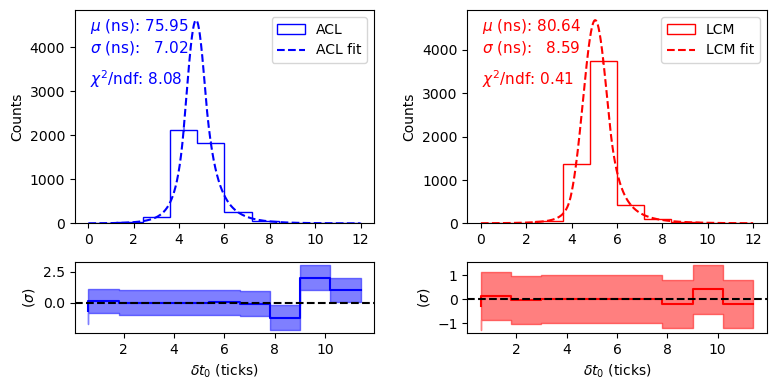

In [90]:
def double_sided_crystal_ball(x, beta1, m1, beta2, m2, loc, scale, amplitude):
    """
    A smooth Double-Sided Crystal Ball function.

    Parameters:
    - x: Data points.
    - beta1, m1: Left tail parameters (beta1 = tail exponent, m1 = curvature).
    - beta2, m2: Right tail parameters.
    - loc: Center of the distribution (mean).
    - scale: Core width (sigma).
    - amplitude: Scaling factor.

    Returns:
    - Smooth DSCB function values.
    """

    # Normalized distance from mean
    t = (x - loc) / scale

    # Transition points
    left_cutoff = -beta1
    right_cutoff = beta2

    y = np.zeros_like(t)

    # Left tail (x < loc - beta1 * scale)
    left_mask = t < left_cutoff
    if np.any(left_mask):
        A1 = (m1 / beta1) ** m1 * np.exp(-0.5 * beta1 ** 2)
        B1 = m1 / beta1 - beta1
        y[left_mask] = A1 * (B1 - t[left_mask]) ** -m1

    # Core Gaussian (-beta1 < t < beta2)
    core_mask = (t >= left_cutoff) & (t <= right_cutoff)
    if np.any(core_mask):
        y[core_mask] = np.exp(-0.5 * t[core_mask] ** 2)

    # Right tail (x > loc + beta2 * scale)
    right_mask = t > right_cutoff
    if np.any(right_mask):
        A2 = (m2 / beta2) ** m2 * np.exp(-0.5 * beta2 ** 2)
        B2 = m2 / beta2 - beta2
        y[right_mask] = A2 * (B2 + t[right_mask]) ** -m2

    return amplitude * y


def plot_histogram_and_fit(ax_main, ax_resid, delta_t, color, label, nbins=10, print_text=False, offset=0.0):
    # Histogram
    ax_main.hist(delta_t, bins=nbins, range=(0, tolerance), histtype='step', color=color, label=label)

    # Bin calculations
    hist, bin_edges = np.histogram(delta_t, bins=nbins, range=(0, tolerance))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    sqrtN = np.sqrt(hist)
    ax_main.errorbar(bin_centers, hist, yerr=sqrtN, fmt='none', color=color, alpha=0.5)

    # Fit Double-sided Crystal Ball
    param_bounds = ([0.1, 0.1, 0.1, 0.1, -np.inf, 1e-6, 1e-6], [10, 10, 10, 10, np.inf, np.inf, np.inf])
    p0 = [1.5, 2.0, 1.5, 2.0, np.mean(delta_t), np.std(delta_t), max(hist)]

    # loop over parameters and print lower bound < central value < upper bound
    for i, p in enumerate(p0):
        print(f'Initial guess for parameter {i}: {p} ({param_bounds[0][i]} < {p} < {param_bounds[1][i]})')

    popt, _ = curve_fit(double_sided_crystal_ball, bin_centers, hist, p0=p0, bounds=param_bounds, maxfev=10000)
    chisq_ndf = np.sum(((hist - double_sided_crystal_ball(bin_centers, *popt)) ** 2) / sqrtN) / (len(hist) - len(p0))

    # Plot fit
    ax_main.plot(interp_bin_centres, double_sided_crystal_ball(interp_bin_centres, *popt), color=color, linestyle='--', label=f'{label} fit')

    # Labels
    ax_main.set_ylabel('Counts')
    ax_main.legend()

    # Residuals
    resids = (hist - double_sided_crystal_ball(bin_centers, *popt))
    ax_resid.step(bin_centers, resids/sqrtN, color=color)
    ax_resid.fill_between(bin_centers, (resids-sqrtN)/sqrtN, (resids+sqrtN)/sqrtN, color=color, alpha=0.5, step='pre')
    ax_resid.axhline(0, color='k', linestyle='--')
    ax_resid.set_xlabel(r'$\delta t_0$ (ticks)')
    ax_resid.set_ylabel(r'($\sigma$)')

    if print_text:
        ax_main.text(
            0.05, 0.90-offset, f'$\mu$ (ns): {popt[4]*16:.2f}',
            transform=ax_main.transAxes, color=color, fontsize=11)
        ax_main.text(
            0.05, 0.80-offset, f'$\sigma$ (ns):   {popt[5]*16:.2f}',
            transform=ax_main.transAxes, color=color, fontsize=11)
        ax_main.text(
            0.05, 0.65-offset, f'$\chi^2$/ndf: {chisq_ndf:.2f}',
            transform=ax_main.transAxes, color=color, fontsize=11)

# Set up figure with GridSpec
fig, ax = plt.subplots(2, 2, figsize=(8, 4), gridspec_kw={'height_ratios': [3, 1]})
interp_bin_centres = np.linspace(0, tolerance, 1000)

# Plot ACL
plot_histogram_and_fit(ax[0, 0], ax[1, 0], acl_delta_t, 'blue', 'ACL', print_text=True)

# Plot LCM
plot_histogram_and_fit(ax[0, 1], ax[1, 1], lcm_delta_t, 'red', 'LCM', print_text=True)

# Adjust layout
plt.tight_layout()
plt.show()

Initial guess for parameter 0: 1.5 (0.1 < 1.5 < 10)
Initial guess for parameter 1: 2.0 (0.1 < 2.0 < 10)
Initial guess for parameter 2: 1.5 (0.1 < 1.5 < 10)
Initial guess for parameter 3: 2.0 (0.1 < 2.0 < 10)
Initial guess for parameter 4: 4.877539376981983 (-inf < 4.877539376981983 < inf)
Initial guess for parameter 5: 0.8936579914794047 (1e-06 < 0.8936579914794047 < inf)
Initial guess for parameter 6: 2127 (1e-06 < 2127 < inf)
Initial guess for parameter 0: 1.5 (0.1 < 1.5 < 10)
Initial guess for parameter 1: 2.0 (0.1 < 2.0 < 10)
Initial guess for parameter 2: 1.5 (0.1 < 1.5 < 10)
Initial guess for parameter 3: 2.0 (0.1 < 2.0 < 10)
Initial guess for parameter 4: 5.227574605451975 (-inf < 5.227574605451975 < inf)
Initial guess for parameter 5: 0.8421923711927389 (1e-06 < 0.8421923711927389 < inf)
Initial guess for parameter 6: 3738 (1e-06 < 3738 < inf)


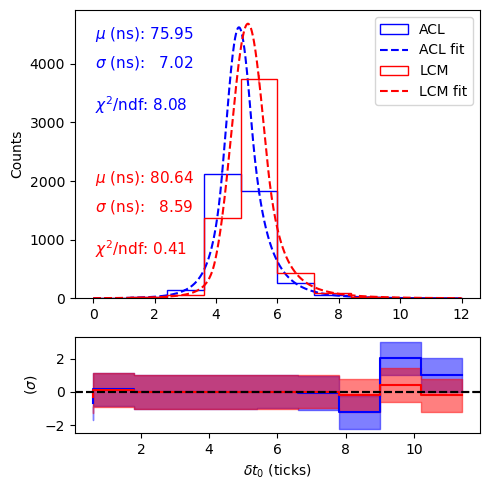

In [91]:
# Set up figure with GridSpec
fig, ax = plt.subplots(2, 1, figsize=(5, 5), gridspec_kw={'height_ratios': [3, 1]})
interp_bin_centres = np.linspace(0, tolerance, 1000)

# Plot ACL
plot_histogram_and_fit(ax[0], ax[1], acl_delta_t, 'b', 'ACL', print_text=True)

# Plot LCM
plot_histogram_and_fit(ax[0], ax[1], lcm_delta_t, 'r', 'LCM', print_text=True, offset=0.5)

# Adjust layout
plt.tight_layout()
plt.show()

In [92]:
# Initialize totals for ArClight (ACL) and LCM
totals = {
    "acl_rec_true_hits": 0, "acl_true_hits": 0, "acl_rec_hits": 0, "acl_delta_t": [],
    "lcm_rec_true_hits": 0, "lcm_true_hits": 0, "lcm_rec_hits": 0, "lcm_delta_t": []
}

# Binned by pileup
totals_pu = {
    "acl_rec_true_hits_pu": [], "acl_true_hits_pu": [], "acl_rec_hits_pu": [], "acl_delta_t_pu": [],
    "lcm_rec_true_hits_pu": [], "lcm_true_hits_pu": [], "lcm_rec_hits_pu": [], "lcm_delta_t_pu": []
}

# Loop over files
for i_file in tqdm(range(nfiles), desc="Processing Files"):

    # Load true hits and hits array
    true_hits = pd.read_csv(true_hits_filenames[i_file])
    hits_arr = np.load(hits_filenames[i_file])['arr_0']

    # Precompute true hit indices for each event and TPC
    grouped_true_hits = true_hits.groupby(['event_id', 'tpc_num'])['start_time_idx'].apply(np.array).to_dict()

    # Process hits per event and trap
    for i_evt_lrs in range(hits_arr.shape[0]):  # Loop over events
        for i_trap in range(hits_arr.shape[1]):  # Loop over traps

            # Determine if the trap is ACL or LCM
            is_acl = i_trap % 2 == 0
            i_tpc = i_trap // 2

            # Get true hit indices for this event & TPC
            true_hit_idxs_tpc = grouped_true_hits.get((i_evt_lrs, i_tpc), np.array([]))

            # Extract nonzero hit indices
            hit_indices = np.where(hits_arr[i_evt_lrs, i_trap] > 0)[0]

            # Recorded hit counting
            for i_hit in hit_indices:
                if is_acl:
                    totals["acl_rec_hits"] += 1
                    totals_pu["acl_rec_hits_pu"].append(len(true_hit_idxs_tpc))
                else:
                    totals["lcm_rec_hits"] += 1
                    totals_pu["lcm_rec_hits_pu"].append(len(true_hit_idxs_tpc))

            # Correctly count true hits (restore per-hit counting)
            for true_hit_idx in true_hit_idxs_tpc:
                if is_acl:
                    totals["acl_true_hits"] += 1
                    totals_pu["acl_true_hits_pu"].append(len(true_hit_idxs_tpc))
                    if hit_indices.size > 0:
                        delta_ts = hit_indices - true_hit_idx
                        delta_t = delta_ts[(delta_ts < tolerance) & (delta_ts > 0)]
                        if delta_t.size > 0:
                            totals["acl_delta_t"].append(min(delta_t))
                            # remove min(delta_t) from the list of available hits to match
                            hit_indices = hit_indices[delta_ts != min(delta_t)]
                            totals["acl_rec_true_hits"] += 1
                            totals_pu["acl_rec_true_hits_pu"].append(len(true_hit_idxs_tpc))
                else:
                    totals["lcm_true_hits"] += 1
                    totals_pu["lcm_true_hits_pu"].append(len(true_hit_idxs_tpc))
                    if hit_indices.size > 0:
                        delta_ts = hit_indices - true_hit_idx
                        delta_t = delta_ts[(delta_ts < tolerance) & (delta_ts > 0)]
                        if delta_t.size > 0:
                            totals["lcm_delta_t"].append(min(delta_t))
                            # remove min(delta_t) from the list of available hits to match
                            hit_indices = hit_indices[delta_ts != min(delta_t)]
                            totals["lcm_rec_true_hits"] += 1
                            totals_pu["lcm_rec_true_hits_pu"].append(len(true_hit_idxs_tpc))


# Compute Efficiency & Fake Rate
def compute_metrics(rec_true_hits, true_hits, rec_hits):
    eff = rec_true_hits / true_hits if true_hits > 0 else 0
    fake_rate = 1 - (rec_true_hits / rec_hits) if rec_hits > 0 else 0
    return eff, fake_rate

acl_eff, acl_fake_rate = compute_metrics(
    totals["acl_rec_true_hits"], totals["acl_true_hits"], totals["acl_rec_hits"]
)
lcm_eff, lcm_fake_rate = compute_metrics(
    totals["lcm_rec_true_hits"], totals["lcm_true_hits"], totals["lcm_rec_hits"]
)

print(f'ACL Efficiency: {acl_eff:.2f}')
print(f'ACL Fake Rate: {acl_fake_rate:.2f}')
print(f'LCM Efficiency: {lcm_eff:.2f}')
print(f'LCM Fake Rate: {lcm_fake_rate:.2f}')

Processing Files: 100%|██████████| 6/6 [00:00<00:00, 38.93it/s]

ACL Efficiency: 0.68
ACL Fake Rate: 0.08
LCM Efficiency: 0.88
LCM Fake Rate: 0.19


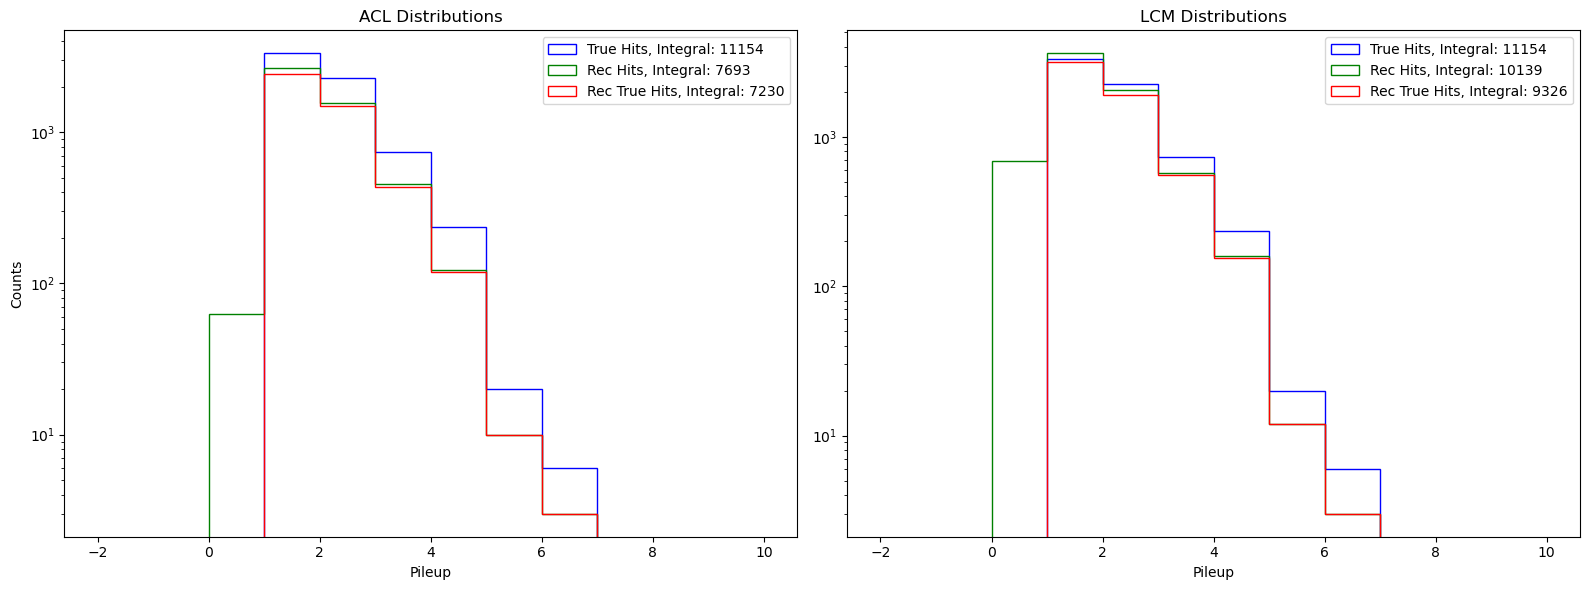

In [93]:
# Create side-by-side subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# ACL distributions
acl_pileup_true = totals_pu["acl_true_hits_pu"]
acl_pileup_rec = totals_pu["acl_rec_hits_pu"]
acl_pileup_rec_true = totals_pu["acl_rec_true_hits_pu"]
acl_integral_true = np.sum(acl_pileup_true)
acl_integral_rec = np.sum(acl_pileup_rec)
acl_integral_rec_true = np.sum(acl_pileup_rec_true)
ax[0].hist(acl_pileup_true, bins=12, range=(-2, 10), histtype='step', color='b', label='True Hits, Integral: {:.0f}'.format(acl_integral_true))
ax[0].hist(acl_pileup_rec, bins=12, range=(-2, 10), histtype='step', color='g', label='Rec Hits, Integral: {:.0f}'.format(acl_integral_rec))
ax[0].hist(acl_pileup_rec_true, bins=12, range=(-2, 10), histtype='step', color='r', label='Rec True Hits, Integral: {:.0f}'.format(acl_integral_rec_true))
ax[0].set_xlabel('Pileup')
ax[0].set_ylabel('Counts')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title('ACL Distributions')

# LCM distributions
lcm_pileup_true = totals_pu["lcm_true_hits_pu"]
lcm_pileup_rec = totals_pu["lcm_rec_hits_pu"]
lcm_pileup_rec_true = totals_pu["lcm_rec_true_hits_pu"]
lcm_integral_true = np.sum(lcm_pileup_true)
lcm_integral_rec = np.sum(lcm_pileup_rec)
lcm_integral_rec_true = np.sum(lcm_pileup_rec_true)
ax[1].hist(lcm_pileup_true, bins=12, range=(-2, 10), histtype='step', color='b', label='True Hits, Integral: {:.0f}'.format(lcm_integral_true))
ax[1].hist(lcm_pileup_rec, bins=12, range=(-2, 10), histtype='step', color='g', label='Rec Hits, Integral: {:.0f}'.format(lcm_integral_rec))
ax[1].hist(lcm_pileup_rec_true, bins=12, range=(-2, 10), histtype='step', color='r', label='Rec True Hits, Integral: {:.0f}'.format(lcm_integral_rec_true))
ax[1].set_xlabel('Pileup')
ax[1].set_yscale('log')
ax[1].legend()
ax[1].set_title('LCM Distributions')

plt.tight_layout()
plt.show()




In [94]:
# vectorised version of clopper_pearson_interval
import numpy as np
import scipy.stats as st

def clopper_pearson_interval_numpy(k, n, alpha=0.05):
    """
    Vectorized Clopper-Pearson confidence interval for binomial proportions.

    Parameters:
    k : array-like
        Number of successes (can be an array).
    n : array-like
        Number of trials (can be an array).
    alpha : float, optional
        Significance level, default is 0.05 for a 95% confidence interval.

    Returns:
    ci_lower : ndarray
        Lower bound of the confidence interval.
    ci_upper : ndarray
        Upper bound of the confidence interval.
    """
    k = np.asarray(k, dtype=np.int64)
    n = np.asarray(n, dtype=np.int64)

    # Ensure valid values
    if np.any(k > n):
        raise ValueError("Number of successes k cannot be greater than number of trials n")

    alpha_2 = alpha / 2

    # Compute lower bound
    ci_lower = np.where(
        k > 0,
        st.beta.ppf(alpha_2, k, n - k + 1),
        0.0  # If k == 0, lower bound is 0
    )
    #ci_lower -= k/n

    # Compute upper bound
    ci_upper = np.where(
        k < n,
        st.beta.ppf(1 - alpha_2, k + 1, n - k),
        1.0  # If k == n, upper bound is 1
    )
    #ci_upper -= k/n

    return ci_lower, ci_upper

In [95]:
# Define bin edges
pu_bins = np.linspace(0, 6, 7)  # Ensure bins cover valid pileup values
dt_bins = np.linspace(0, tolerance, tolerance + 1)

# ACL histograms
acl_delta_t_puhist, _, _ = np.histogram2d(totals_pu["acl_rec_true_hits_pu"], totals["acl_delta_t"], bins=[pu_bins, dt_bins])
acl_rec_true_hits_puhist, _ = np.histogram(totals_pu["acl_rec_true_hits_pu"], bins=pu_bins)
acl_true_hits_puhist, _ = np.histogram(totals_pu["acl_true_hits_pu"], bins=pu_bins)  # Binwise true hits
acl_rec_hits_puhist, _ = np.histogram(totals_pu["acl_rec_hits_pu"], bins=pu_bins)

# LCM histograms
lcm_delta_t_puhist, _, _ = np.histogram2d(totals_pu["lcm_rec_true_hits_pu"], totals["lcm_delta_t"], bins=[pu_bins, dt_bins])
lcm_rec_true_hits_puhist, _ = np.histogram(totals_pu["lcm_rec_true_hits_pu"], bins=pu_bins)
lcm_true_hits_puhist, _ = np.histogram(totals_pu["lcm_true_hits_pu"], bins=pu_bins)  # Binwise true hits
lcm_rec_hits_puhist, _ = np.histogram(totals_pu["lcm_rec_hits_pu"], bins=pu_bins)

# ACL efficiency & error (binwise)
acl_eff_pu = acl_rec_true_hits_puhist / acl_true_hits_puhist
acl_eff_pu_err = clopper_pearson_interval_numpy(acl_rec_true_hits_puhist, acl_true_hits_puhist)

# ACL fake rate & error (binwise)
acl_fake_rate_pu = 1 - (acl_rec_true_hits_puhist / acl_rec_hits_puhist)
acl_fake_rate_pu_err = clopper_pearson_interval_numpy(acl_rec_true_hits_puhist, acl_rec_hits_puhist)

# LCM efficiency & error (binwise)
lcm_eff_pu = lcm_rec_true_hits_puhist / lcm_true_hits_puhist
lcm_eff_pu_err = clopper_pearson_interval_numpy(lcm_rec_true_hits_puhist, lcm_true_hits_puhist)

# LCM fake rate & error (binwise)
lcm_fake_rate_pu = 1 - (lcm_rec_true_hits_puhist / lcm_rec_hits_puhist)
lcm_fake_rate_pu_err = clopper_pearson_interval_numpy(lcm_rec_true_hits_puhist, lcm_rec_hits_puhist)


/var/folders/rc/blk_p25x629bs2hm6s03qd7r0000gp/T/ipykernel_38275/2513010131.py:18: RuntimeWarning: invalid value encountered in divide
  acl_eff_pu = acl_rec_true_hits_puhist / acl_true_hits_puhist
/var/folders/rc/blk_p25x629bs2hm6s03qd7r0000gp/T/ipykernel_38275/2513010131.py:26: RuntimeWarning: invalid value encountered in divide
  lcm_eff_pu = lcm_rec_true_hits_puhist / lcm_true_hits_puhist


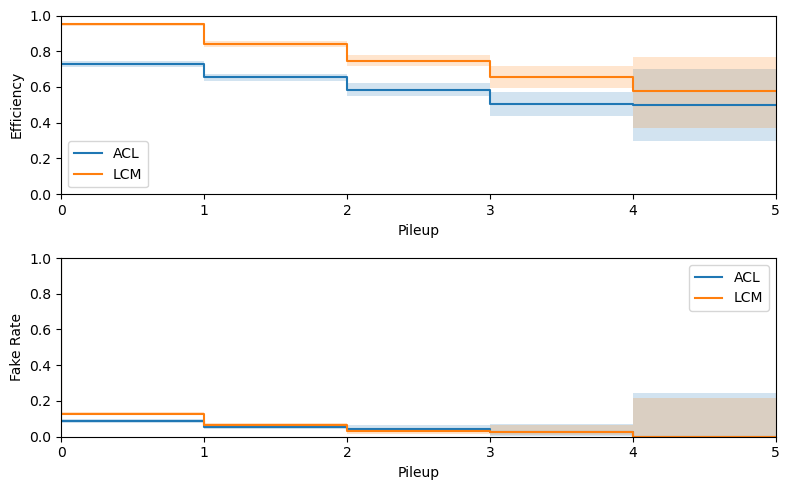

In [96]:
# plot efficiency and fake rate as a function of pileup
fig, ax = plt.subplots(2, figsize=(8, 5))

# plot acl efficiency
ax[0].step(pu_bins[:-1], acl_eff_pu, label='ACL')
ax[0].fill_between(pu_bins[:-1], acl_eff_pu_err[0], acl_eff_pu_err[1], step='pre', alpha=0.2)
# plot lcm efficiency
ax[0].step(pu_bins[:-1], lcm_eff_pu, label='LCM')
ax[0].fill_between(pu_bins[:-1], lcm_eff_pu_err[0], lcm_eff_pu_err[1], step='pre', alpha=0.2)
# formatting
ax[0].set_ylabel('Efficiency')
ax[0].set_xlabel('Pileup')
ax[0].set_xlim(0, 5)
ax[0].set_ylim(0, 1)
ax[0].legend()

# plot acl fake rate
ax[1].step(pu_bins[:-1], acl_fake_rate_pu, label='ACL')
ax[1].fill_between(pu_bins[:-1], 1-acl_fake_rate_pu_err[0], 1-acl_fake_rate_pu_err[1], step='pre', alpha=0.2)
# plot lcm fake rate
ax[1].step(pu_bins[:-1], lcm_fake_rate_pu, label='LCM')
ax[1].fill_between(pu_bins[:-1], 1-lcm_fake_rate_pu_err[0], 1-lcm_fake_rate_pu_err[1], step='pre', alpha=0.2)
# formatting
ax[1].set_ylabel('Fake Rate')
ax[1].set_xlabel('Pileup')
ax[1].set_xlim(0, 5)
ax[1].set_ylim(0, 1)
ax[1].legend()

plt.tight_layout()
plt.show()

/var/folders/rc/blk_p25x629bs2hm6s03qd7r0000gp/T/ipykernel_38275/1433994247.py:38: RuntimeWarning: invalid value encountered in divide
  ratio_fake = lcm_fake_rate_pu / acl_fake_rate_pu
/var/folders/rc/blk_p25x629bs2hm6s03qd7r0000gp/T/ipykernel_38275/1433994247.py:39: RuntimeWarning: divide by zero encountered in divide
  acl_fake_err_scaled = (1 - np.array(acl_fake_rate_pu_err)) / acl_fake_rate_pu
/var/folders/rc/blk_p25x629bs2hm6s03qd7r0000gp/T/ipykernel_38275/1433994247.py:39: RuntimeWarning: invalid value encountered in divide
  acl_fake_err_scaled = (1 - np.array(acl_fake_rate_pu_err)) / acl_fake_rate_pu
/var/folders/rc/blk_p25x629bs2hm6s03qd7r0000gp/T/ipykernel_38275/1433994247.py:40: RuntimeWarning: divide by zero encountered in divide
  lcm_fake_err_scaled = (1 - np.array(lcm_fake_rate_pu_err)) / acl_fake_rate_pu
/var/folders/rc/blk_p25x629bs2hm6s03qd7r0000gp/T/ipykernel_38275/1433994247.py:40: RuntimeWarning: invalid value encountered in divide
  lcm_fake_err_scaled = (1 - np.

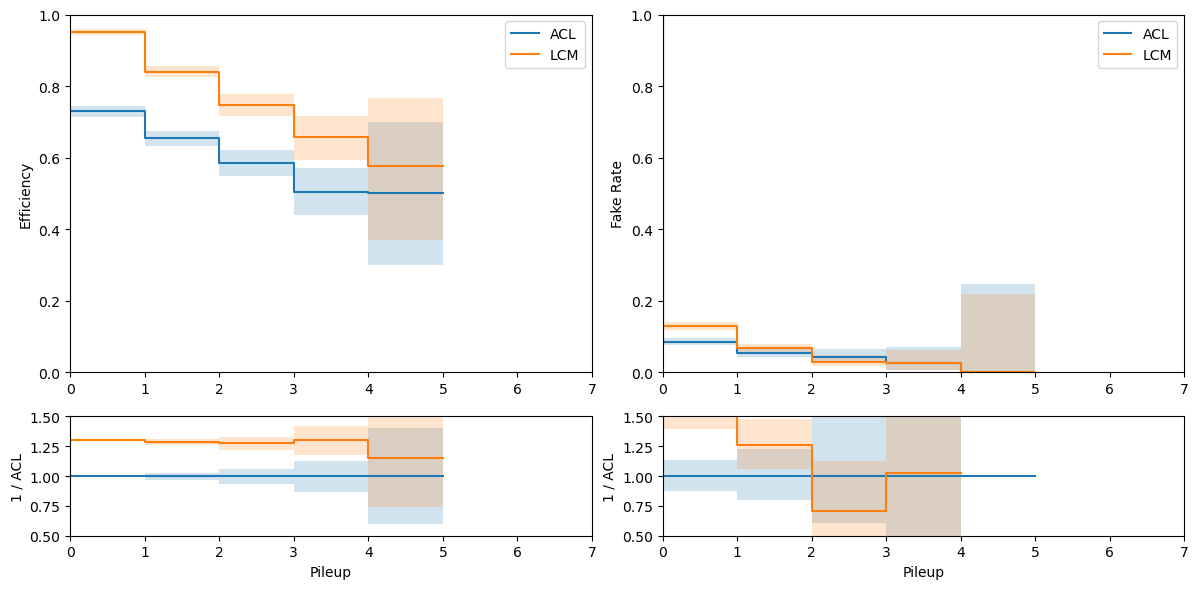

In [97]:

fig, ax = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 1]})

# Plot ACL and LCM efficiency (top left)
ax[0, 0].step(pu_bins[:-1], acl_eff_pu, label='ACL')
ax[0, 0].fill_between(pu_bins[:-1], acl_eff_pu_err[0], acl_eff_pu_err[1], step='pre', alpha=0.2)
ax[0, 0].step(pu_bins[:-1], lcm_eff_pu, label='LCM')
ax[0, 0].fill_between(pu_bins[:-1], lcm_eff_pu_err[0], lcm_eff_pu_err[1], step='pre', alpha=0.2)
ax[0, 0].set_ylabel('Efficiency')
ax[0, 0].set_xlim(0, 7)
ax[0, 0].set_ylim(0, 1)
ax[0, 0].legend()

# Plot ACL and LCM fake rate (top right)
ax[0, 1].step(pu_bins[:-1], acl_fake_rate_pu, label='ACL')
ax[0, 1].fill_between(pu_bins[:-1], 1 - acl_fake_rate_pu_err[0], 1 - acl_fake_rate_pu_err[1], step='pre', alpha=0.2)
ax[0, 1].step(pu_bins[:-1], lcm_fake_rate_pu, label='LCM')
ax[0, 1].fill_between(pu_bins[:-1], 1 - lcm_fake_rate_pu_err[0], 1 - lcm_fake_rate_pu_err[1], step='pre', alpha=0.2)
ax[0, 1].set_ylabel('Fake Rate')
ax[0, 1].set_xlim(0, 7)
ax[0, 1].set_ylim(0, 1)
ax[0, 1].legend()

# Plot efficiency ratio (bottom left)
ratio_eff = lcm_eff_pu / acl_eff_pu
acl_eff_err_scaled = acl_eff_pu_err / acl_eff_pu
lcm_eff_err_scaled = lcm_eff_pu_err / acl_eff_pu

ax[1, 0].step(pu_bins[:-1], [1] * len(pu_bins[:-1]), label='ACL')
ax[1, 0].fill_between(pu_bins[:-1], acl_eff_err_scaled[0], acl_eff_err_scaled[1], step='pre', alpha=0.2)
ax[1, 0].step(pu_bins[:-1], ratio_eff, label='LCM')
ax[1, 0].fill_between(pu_bins[:-1], lcm_eff_err_scaled[0], lcm_eff_err_scaled[1], step='pre', alpha=0.2)
ax[1, 0].set_ylabel('1 / ACL')
ax[1, 0].set_xlabel('Pileup')
ax[1, 0].set_xlim(0, 7)
ax[1, 0].set_ylim(0.5, 1.5)

# Plot fake rate ratio (bottom right)
ratio_fake = lcm_fake_rate_pu / acl_fake_rate_pu
acl_fake_err_scaled = (1 - np.array(acl_fake_rate_pu_err)) / acl_fake_rate_pu
lcm_fake_err_scaled = (1 - np.array(lcm_fake_rate_pu_err)) / acl_fake_rate_pu

ax[1, 1].step(pu_bins[:-1], [1] * len(pu_bins[:-1]), label='ACL')
ax[1, 1].fill_between(pu_bins[:-1],  acl_fake_err_scaled[0], acl_fake_err_scaled[1], step='pre', alpha=0.2)
ax[1, 1].step(pu_bins[:-1], ratio_fake, label='LCM')
ax[1, 1].fill_between(pu_bins[:-1], lcm_fake_err_scaled[0], lcm_fake_err_scaled[1], step='pre', alpha=0.2)
ax[1, 1].set_ylabel('1 / ACL')
ax[1, 1].set_xlabel('Pileup')
ax[1, 1].set_xlim(0, 7)
ax[1, 1].set_ylim(0.5, 1.5)

plt.tight_layout()
plt.show()



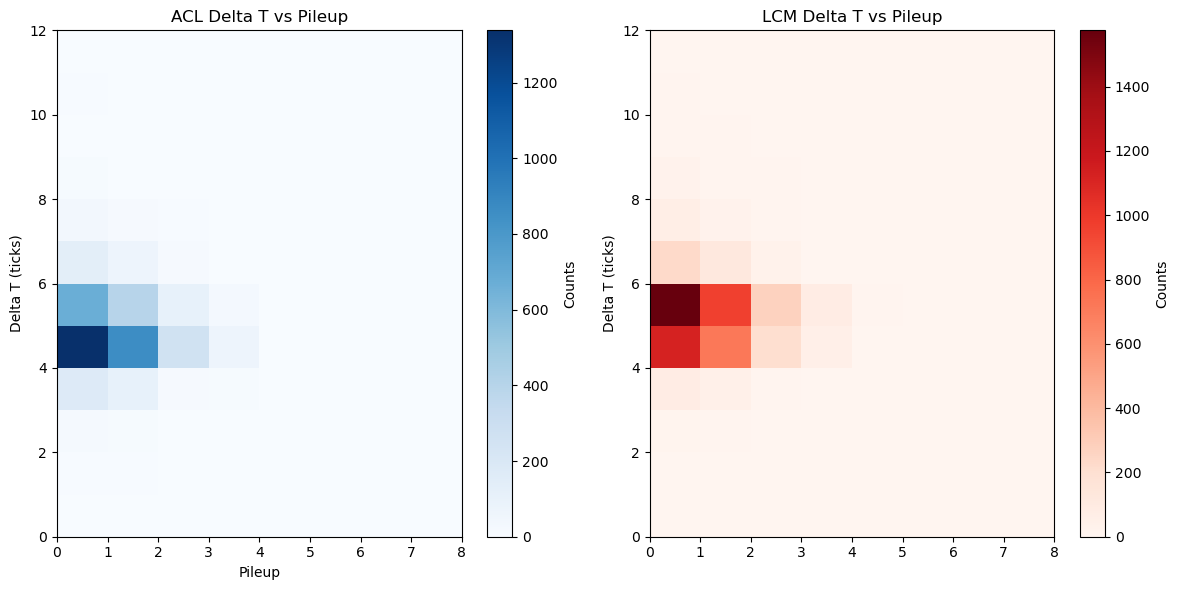

In [98]:
# first plot the pileup vs delta t space for each trap type
pu_bins = np.linspace(0, 8, 9)  # Ensure bins cover valid pileup values

# 2d heatmap
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ACL
hist_acl_data, xedges_acl, yedges_acl, _ = ax[0].hist2d(np.array(totals_pu["acl_rec_true_hits_pu"])-1, totals["acl_delta_t"], bins=[pu_bins, dt_bins], cmap='Blues')


ax[0].set_xlabel('Pileup')
ax[0].set_ylabel('Delta T (ticks)')
ax[0].set_title('ACL Delta T vs Pileup')
# LCM
hist_lcm_data, xedges_lcm, yedges_lcm, _ = ax[1].hist2d(np.array(totals_pu["lcm_rec_true_hits_pu"])-1, totals["lcm_delta_t"], bins=[pu_bins, dt_bins], cmap='Reds')


ax[1].set_ylabel('Delta T (ticks)')
ax[1].set_title('LCM Delta T vs Pileup')
# add colorbars
fig.colorbar(ax[0].collections[0], ax=ax[0], label='Counts')
fig.colorbar(ax[1].collections[0], ax=ax[1], label='Counts')
plt.tight_layout()
plt.show()

# then run a double crystal ball fit per trap type in each pilep bin

In [99]:
# take hist_acl_data and make it cumulative in the y-axis and plot

acl_cum_hist = np.cumsum(hist_acl_data, axis=0)

lcm_cum_hist = np.cumsum(hist_lcm_data, axis=0)
